# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [154]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from features import features,calc_features

## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [155]:
# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

# start_datetime = datetime.datetime.strptime("2022-1-11 00:00:00", "%Y-%m-%d %H:%M:%S")
# end_datetime = datetime.datetime.strptime("2018-01-07 00:00:00", "%Y-%m-%d %H:%M:%S")
# target_coin = "FX_BTC_JPY"


# ohlc_list=[]
# while start_datetime > end_datetime:
#     unixtime = start_datetime.timestamp() * 1000
#     response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
#     ohlc_list.extend(response)
#     start_datetime -= timedelta(minutes=720)
#     time.sleep(1)


# df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
# df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
# df_1m.set_index("timestamp",inplace=True)
# df_1m.sort_index(inplace=True)
# display(df_1m)

# df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

1分足のOHLCVを15分足に変換します。

In [156]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-01-06 12:00:00+00:00,2233853.0,2241700.0,2231111.0,2233000.0,729.759980
2018-01-06 12:15:00+00:00,2233000.0,2233458.0,2220132.0,2224899.0,940.678245
2018-01-06 12:30:00+00:00,2224899.0,2231682.0,2222000.0,2226737.0,409.952456
2018-01-06 12:45:00+00:00,2226737.0,2226739.0,2201400.0,2210000.0,1481.500831
2018-01-06 13:00:00+00:00,2210000.0,2228400.0,2205858.0,2224500.0,1050.309835
...,...,...,...,...,...
2022-01-10 11:00:00+00:00,4958884.0,4960090.0,4932203.0,4941332.0,99.690370
2022-01-10 11:15:00+00:00,4941332.0,4950000.0,4920393.0,4935144.0,70.740648
2022-01-10 11:30:00+00:00,4933482.0,4942334.0,4921400.0,4924409.0,54.458842


## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [157]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-01-06 12:00:00+00:00,2233853.0,2241700.0,2231111.0,2233000.0,729.759980,0.0
2018-01-06 12:15:00+00:00,2233000.0,2233458.0,2220132.0,2224899.0,940.678245,0.0
2018-01-06 12:30:00+00:00,2224899.0,2231682.0,2222000.0,2226737.0,409.952456,0.0
2018-01-06 12:45:00+00:00,2226737.0,2226739.0,2201400.0,2210000.0,1481.500831,0.0
2018-01-06 13:00:00+00:00,2210000.0,2228400.0,2205858.0,2224500.0,1050.309835,0.0
...,...,...,...,...,...,...
2022-01-10 11:00:00+00:00,4958884.0,4960090.0,4932203.0,4941332.0,99.690370,0.0
2022-01-10 11:15:00+00:00,4941332.0,4950000.0,4920393.0,4935144.0,70.740648,0.0
2022-01-10 11:30:00+00:00,4933482.0,4942334.0,4921400.0,4924409.0,54.458842,0.0


## 特徴量エンジニアリング

No handles with labels found to put in legend.


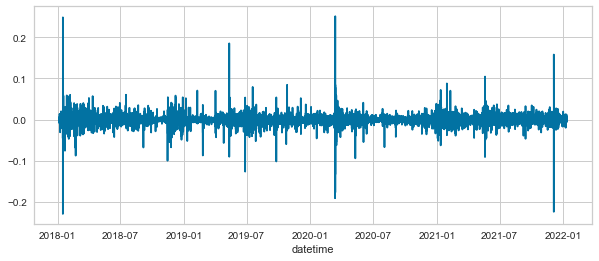

In [158]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    periods = [3,5,8,13,21,55,89]
    for period in periods:
        col = 'RETURN_{}'.format(period)
        df[col] = \
            df['cl'].pct_change(period)

        if period !=1:
            col = 'VOL_{}'.format(period)
            df[col] = \
                np.log(df['cl']).diff().rolling(period).std()
            
        col = 'MA_GAP_{}'.format(period)
        df[col] = \
            df['cl'] / (df['cl'].rolling(period).mean())
    
    df['hilo'] = df['hi'] - df['lo']
    df['PER_HILO'] = df['hilo'] / (hilo+1)
    df['opcl'] = df['op'] - df['cl']
    df['PER_OPCL'] = df['opcl'] / (hilo+1)
    df['CL_LOG'] = np.log(df['cl']).diff()

    # df['LOG_OPCL'] = df['opcl'].apply(np.log)

    return df

df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)

# df['opcl'].hist(alpha=0.3, label='買い')
# df['LOG_OPCL'].hist(alpha=0.3, label='売り')
# plt.title('エグジットまでの時間分布',fontname="Meiryo")
# plt.legend( prop={"family":"Meiryo"})
# plt.show()

# プロット
fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(df['cl'])
ax.plot(df['CL_LOG'])
ax.set_xlabel('datetime')
ax.grid(True)
ax.legend()
plt.show()

df.to_pickle('df_bf_fx_features.pkl')

## 学習に使う特徴量の定義

In [159]:
features = sorted([
#      'ADX',
#     'ADXR',
#     'APO',
#     'AROON_aroondown',
#     'AROON_aroonup',
#     'AROONOSC',
#     'CCI',
#     'DX',
#     'MACD_macd',
#     'MACD_macdsignal',
#     'MACD_macdhist',
#     'MFI',
# #     'MINUS_DI',
# #     'MINUS_DM',
#     'MOM',
# #     'PLUS_DI',
# #     'PLUS_DM',
#     'RSI',
#     'STOCH_slowk',
#     'STOCH_slowd',
#     'STOCHF_fastk',
# #     'STOCHRSI_fastd',
#     'ULTOSC',
#     'WILLR',
# #     'ADOSC',
# #     'NATR',
#     'HT_DCPERIOD',
#     'HT_DCPHASE',
#     'HT_PHASOR_inphase',
#     'HT_PHASOR_quadrature',
#     'HT_TRENDMODE',
#     'BETA',
#     'LINEARREG',
#     'LINEARREG_ANGLE',
#     'LINEARREG_INTERCEPT',
#     'LINEARREG_SLOPE',
#     'STDDEV',
#     'BBANDS_upperband',
#     'BBANDS_middleband',
#     'BBANDS_lowerband',
#     'DEMA',
#     'EMA',
#     'HT_TRENDLINE',
#     'KAMA',
#     'MA',
#     'MIDPOINT',
#     'T3',
#     'TEMA',
#     'TRIMA',
#     'WMA',
    # 'MACD_macd',
    # 'RSI',
    # 'ATR',
    # 'volume',
    'VOL_3',
    'RETURN_3',
    'MA_GAP_3',
    'VOL_5',
    'RETURN_5',
    'MA_GAP_5',
    # 'VOL_21',
    # 'RETURN_21',
    # 'MA_GAP_21',
    # 'VOL_55',
    # 'RETURN_55',
    # 'MA_GAP_55',
    'PER_OPCL',
    'PER_HILO',
    'CL_LOG',
])

print(features)

['CL_LOG', 'MA_GAP_3', 'MA_GAP_5', 'PER_HILO', 'PER_OPCL', 'RETURN_3', 'RETURN_5', 'VOL_3', 'VOL_5']


## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


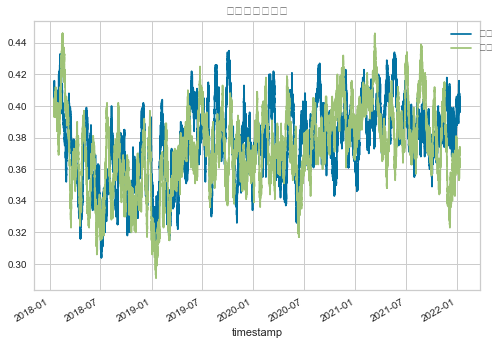

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


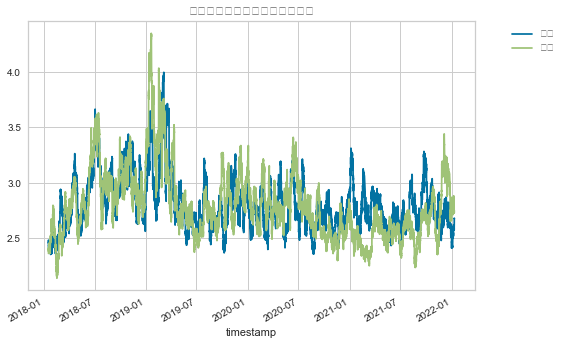

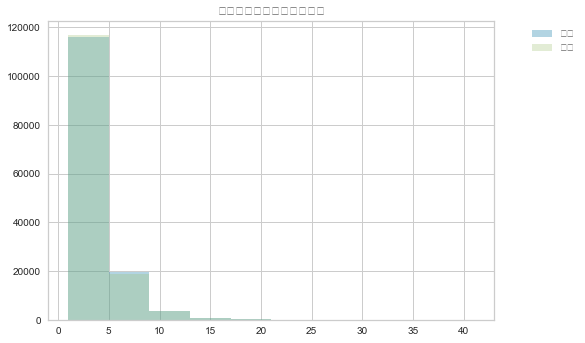

毎時刻、この執行方法でトレードした場合の累積リターン


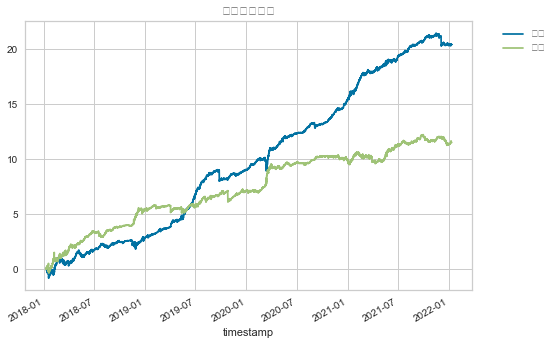

In [160]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
#limit_price_dist = df['ATR'] * 0.5
limit_price_dist = df['ATR'] * 0.496
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_y.pkl')

## モデルの学習とOOS予測値計算

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


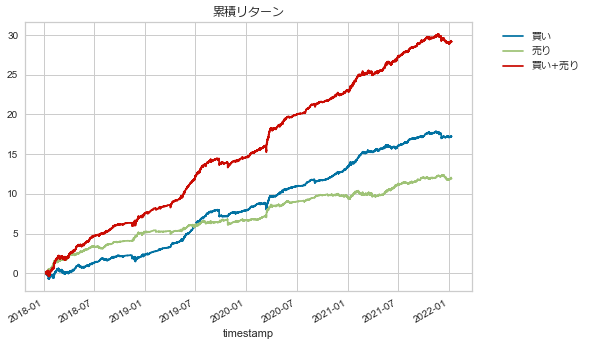

In [161]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
#model = BaggingRegressor(model, random_state=1, n_jobs=1)


# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

df.to_pickle('df_bf_fx_fit.pkl')

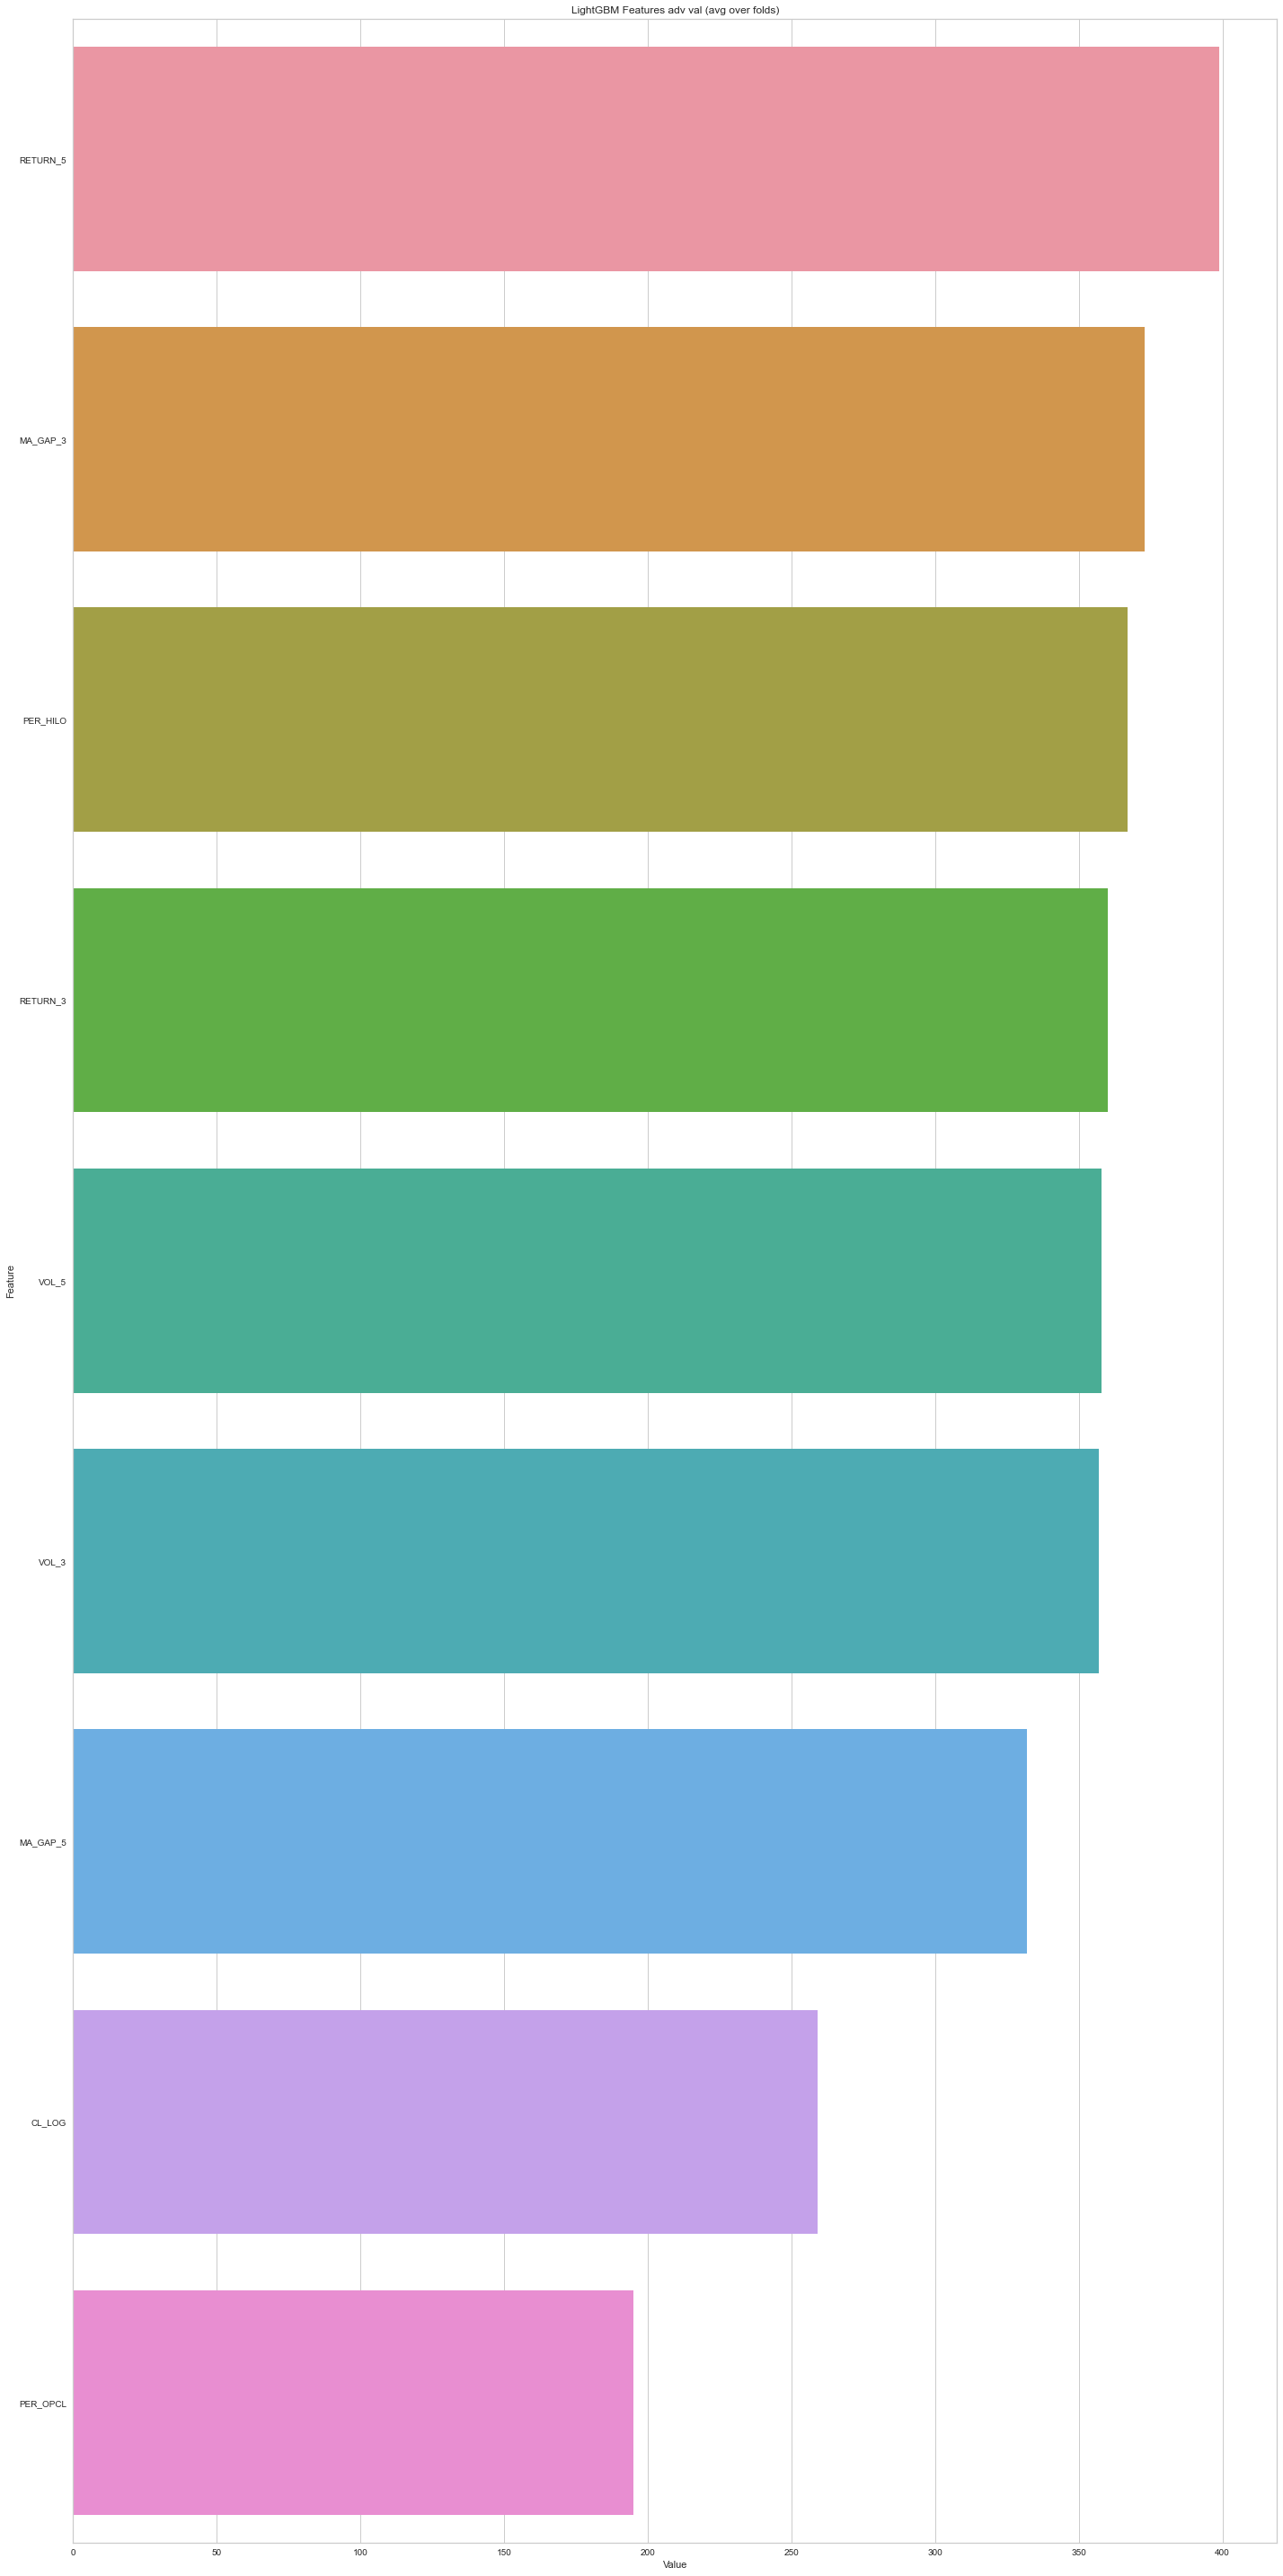

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.07114174 0.07426434]
score mean, std 0.07270303826007962 0.0015613020420357504


In [162]:
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

In [163]:
# from pycaret.regression import *
# import copy
# df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df.dropna()
# features_ybuy = copy.deepcopy(features)
# features_ybuy.append('y_buy')
# exp1 = setup(df[features_ybuy], target = 'y_buy')
# model_pycaret = create_model('lightgbm')


## バックテストと検定

2.321076524434437


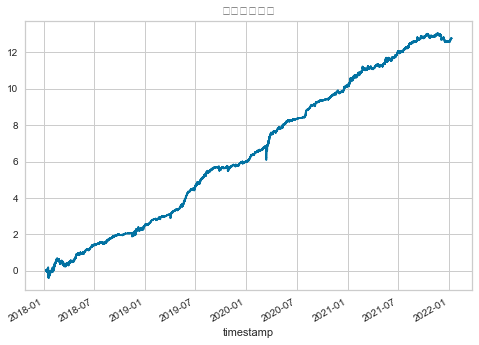

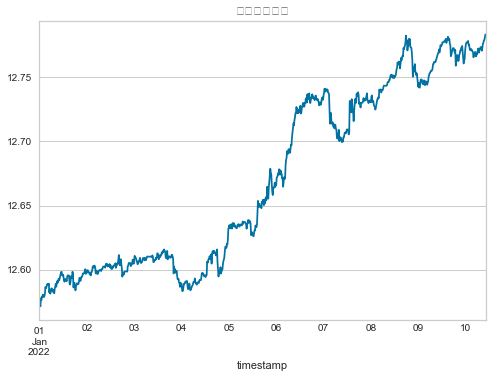

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


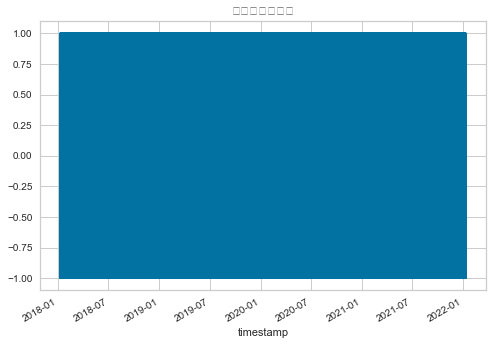

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


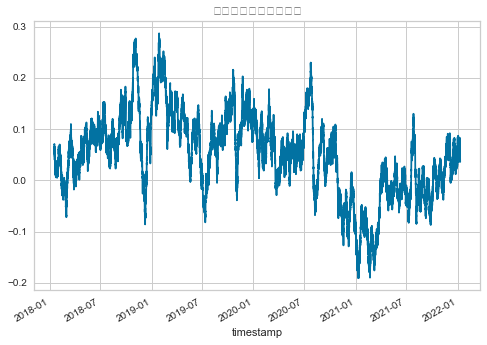

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


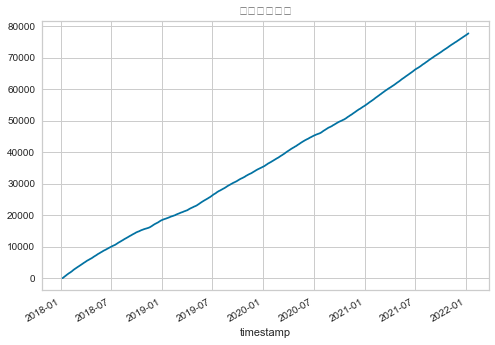

t検定
t値 7.695700303589343
p値 1.416338922817327e-14
p平均法 n = 5
p平均 0.007671633220345794
エラー率 6.920029265746153e-10


In [164]:
#@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None,
              date_time=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    old_ret = 0.0
    print_date = '2021-01-10 00:00:00'
    print_ret = 0.0

    for i in range(n):
        prev_pos = pos

        # exit
        if buy_cost[i]:
        #if sell_entry[i] < 0 and buy_cost[i]:
        #if buy_entry[i] < 0 and buy_cost[i]:
            #vol = np.minimum(1.0, 1 - prev_pos) * (buy_entry[i] > 0)
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
        #if buy_entry[i] < 0 and sell_cost[i]:
        #if sell_entry[i] < 0 and sell_cost[i]:
            #vol = np.minimum(1.0, prev_pos + 1) * (sell_entry[i] > 0)
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] > 0 and buy_cost[i]:
        #if buy_entry[i] > 0 and buy_cost[i] and buy_entry[i] >= sell_entry[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * (buy_entry[i] > 0)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] > 0 and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * (sell_entry[i] > 0)
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos

        if date_time[i] > print_date:
            print_ret += (ret - old_ret)
        old_ret = ret
            

    print(print_ret)
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df_index = df
df_index['datetime'] = pd.to_datetime(df_index.index)
df_index['datetime'] = df_index['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    # buy_entry=df['y_pred_buy'].values > 0,
    # sell_entry=df['y_pred_sell'].values > 0,
    buy_entry=df['y_pred_buy'].values,
    sell_entry=df['y_pred_sell'].values,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
    date_time=df_index['datetime'].values,
)


df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

df[df.index.year == 2022]['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [165]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [166]:
#OHLCV取得
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
unixtime = datetime.datetime.now().timestamp() * 1000
target_coin = "FX_BTC_JPY"
ohlc_list=[]

#1000本以上の1分足を取得
while len(ohlc_list) < 1000:
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
    next_before = current_after - timedelta(minutes=1)
    unixtime = int(next_before.timestamp() * 1000)
    time.sleep(1)

df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)

#15分足に変換
df = pd.DataFrame()
rule = "15T"
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model/model_y_buy_bffx.xz')
model_y_sell = joblib.load('./model/model_y_sell_bffx.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

#ポジションの判定

#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,MA_GAP_89,hilo,PER_HILO,opcl,PER_OPCL,CL_LOG,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-12 12:00:00+00:00,5087495.0,5105186.0,5082400.0,5082400.0,85.041288,NaN,NaN,NaN,NaN,NaN,...,NaN,22786.0,0.004473,5095.0,0.001000,NaN,-0.007433,0.007654,none,sell
2022-01-12 12:15:00+00:00,5082400.0,5115144.0,5081361.0,5108945.0,94.070039,NaN,NaN,NaN,NaN,NaN,...,NaN,33783.0,0.006626,-26545.0,-0.005207,0.005209,-0.007615,0.006565,none,sell
2022-01-12 12:30:00+00:00,5110420.0,5137239.0,5105781.0,5108582.0,139.227306,NaN,NaN,NaN,NaN,NaN,...,NaN,31458.0,0.006142,1838.0,0.000359,-0.000071,-0.001875,0.002815,none,sell
2022-01-12 12:45:00+00:00,5108798.0,5136912.0,5107398.0,5134245.0,90.237589,NaN,NaN,NaN,NaN,NaN,...,NaN,29514.0,0.005762,-25447.0,-0.004968,0.005011,-0.005184,0.003420,none,sell
2022-01-12 13:00:00+00:00,5135493.0,5152433.0,5130877.0,5136166.0,144.758509,11956.362909,-27587.4,-67131.162909,NaN,NaN,...,NaN,21556.0,0.004192,-673.0,-0.000131,0.000374,-0.000054,-0.000469,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13 11:15:00+00:00,5139888.0,5147724.0,5125678.0,5137453.0,61.813885,32630.827306,12740.8,-7149.227306,13304.248899,14066.296738,...,0.995775,22046.0,0.004292,2435.0,0.000474,-0.000201,0.000177,0.000056,buy,sell
2022-01-13 11:30:00+00:00,5137274.0,5149142.0,5136017.0,5148479.0,35.118693,20221.900186,4271.1,-11679.700186,7189.173829,8040.164690,...,0.997927,13125.0,0.002552,-11205.0,-0.002179,0.002144,-0.000065,0.000051,none,sell
2022-01-13 11:45:00+00:00,5148478.0,5148506.0,5134738.0,5136900.0,38.047866,13067.165210,891.6,-11283.965210,6488.402935,8112.525033,...,0.995817,13768.0,0.002678,11578.0,0.002252,-0.002252,0.000065,-0.000040,buy,none


Buy Bitcoin


In [167]:
#初回だけ実行
#!pip install optuna

import optuna
optuna.logging.disable_default_handler()
import warnings
warnings.filterwarnings('ignore')


def calc_y(df,param):
    # 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
    pips = 1

    # ATRで指値距離を計算します
    limit_price_dist = df['ATR'] * param['atr']
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['cl'] - limit_price_dist
    df['sell_price'] = df['cl'] + limit_price_dist

    #df['buy_price'] = df['cl'] + df['BBANDS_lowerband'] 
    #df['sell_price'] = df['cl'] + limit_price_dist 

    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['lo'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['hi'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1

    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料

    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['cl'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['cl'] - 1) + fee,
        0
    )
    return df

df_features = pd.read_pickle('df_bf_fx_features.pkl')
def objective(trial):
    atr = trial.suggest_uniform('atr', 0.0, 2.0)
    param = {"atr":atr}
    df = calc_y(df_features,param)
    score = df['y_buy'].cumsum().iloc[-1] + df['y_sell'].cumsum().iloc[-1]
    print("atr:{} score{}".format(atr,score))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
# プログラムが試行錯誤した結果最も良いパラメータを表示
print("best param: {}".format(study.best_params))
# 最も良いパラメータで実行したときの結果（返り値）を表示
print("best score: {}".format(study.best_value))

atr:1.4409860712653437 score-8.31483984045262
atr:0.8144349713596919 score5.6702469307869805
atr:1.4246834894380749 score-8.67997631156836
atr:1.4129352179003027 score-7.937197134798811
atr:0.8338273380428487 score6.1484486588654
atr:1.3788182461283411 score-11.232483362333681
atr:0.9757445396406035 score-1.677904726428678
atr:0.5937264022317892 score20.544275511094078
atr:1.6286794164661407 score-14.285165895161873
atr:1.8082681852068707 score-14.96574839496986
atr:0.19781665075899812 score9.273832111207803
atr:0.07161530698124807 score-42.790219108499755
atr:0.2451404493413275 score24.51557594879658
atr:0.3917534244295659 score36.05272199355696
atr:0.3892120110507173 score36.2693091975096
atr:0.4749908312174326 score33.79674560865878
atr:0.45345973807278406 score36.0187843421872
atr:0.5859443703687197 score22.429992409557883
atr:1.1547155447447908 score-3.609298060632887
atr:0.2683937237599835 score29.359241582212675
atr:0.03318512708695942 score-47.438860798006736
atr:0.421292927370